In [1]:
import sys

module_dir = '../'

if module_dir not in sys.path:
    sys.path.append(module_dir)

import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
import models
import test_systems_1d as systems_1d
import itertools

# Training

In [2]:
# Display?
display_subset = False
how_many = 5
####################

n_features = 1000
n_targets = n_features

x = np.linspace(-20, 20, n_features)

n_samples_V = 100
n_samples_H_0 = 100

rng = np.random.default_rng(seed=99)
V_arr_train = np.random.uniform(1, 10, n_samples_V)
H_0_arr_train = np.random.uniform(1, 10, n_samples_H_0)

train_params = np.array(list(itertools.product(V_arr_train, H_0_arr_train)))
n_samples_train = train_params.shape[0]

x_train = np.zeros((n_samples_train, n_features))
y_train = np.zeros((n_samples_train, n_targets))

for i, params in enumerate(train_params):
    x_train[i, :] = systems_1d.diffusion(x = x, t = 0, D = 1, V = train_params[i, 0], H_0 = train_params[i, 1])
    y_train[i, :] = systems_1d.diffusion(x = x, t = 5, D = 1, V = train_params[i, 0], H_0 = train_params[i, 1])

    if (i+1) % int(n_samples_train/how_many) == 0 and display_subset:
        print(f'{i+1}/{n_samples_train}: V = {params[0]}, H_0 = {params[1]}')
        plt.figure()
        plt.plot(x, x_train[i, :], label='x_train')
        plt.plot(x, y_train[i, :], label='y_train')
        plt.legend()
        plt.show()


In [3]:
reg = models.first_model(low_dim_x=5, low_dim_y=1)
reg.fit(x_train, y_train, save=True)

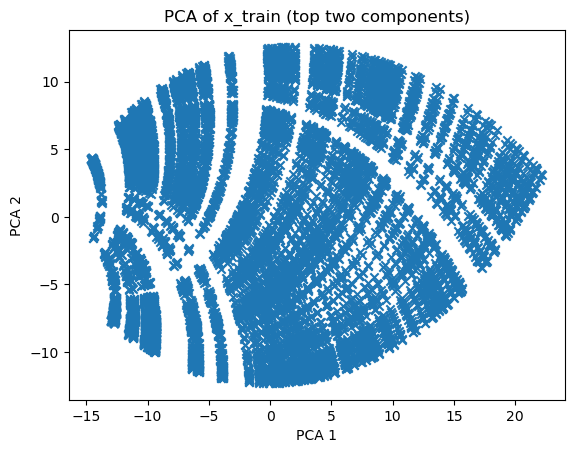

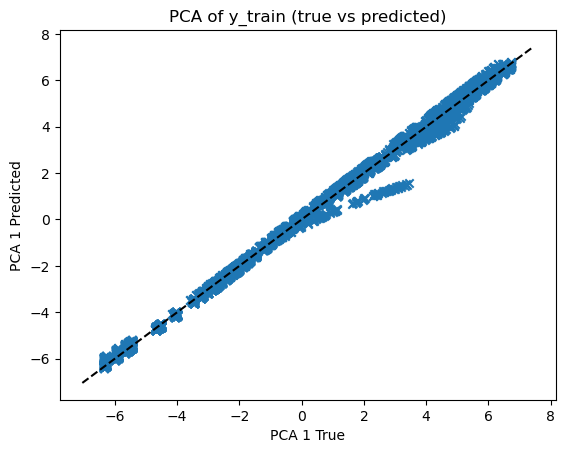

MSE: 0.028958861280172322
Correlation: 0.9988504892822648


In [4]:
# assess how well the low-dimensional regression is doing

plt.figure()
plt.scatter(reg.X_train_low_dim[:, 0], reg.X_train_low_dim[:, 1], marker='x', alpha=1)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA of x_train (top two components)')
plt.show()

plt.figure()
ax = plt.gca()
plt.scatter(reg.Y_train_low_dim[:, 0], reg.Y_train_low_dim_pred[:, 0], marker='x', alpha=1)
plt.plot(np.linspace(min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1]), num=2), np.linspace(min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1]), num=2), linestyle='--', color='black')
plt.xlabel('PCA 1 True')
plt.ylabel('PCA 1 Predicted')
plt.title('PCA of y_train (true vs predicted)')
plt.show()

mse = skl.metrics.mean_squared_error(reg.Y_train_low_dim, reg.Y_train_low_dim_pred)
print(f'MSE: {mse}')
r = np.corrcoef(reg.Y_train_low_dim[:, 0], reg.Y_train_low_dim_pred[:, 0])
print(f'Correlation: {r[0, 1]}')

# Testing

In [9]:
n_samples_V_test = 1000
n_samples_H_0_test = 50

rng = np.random.default_rng(seed=98)
V_arr_test = np.linspace(0.01, 10, n_samples_V_test)
H_0_arr_test = np.linspace(3, 10, n_samples_H_0_test)

test_params = np.array(list(itertools.product(V_arr_test, H_0_arr_test)))
n_samples_test = test_params.shape[0]

x_test = np.zeros((n_samples_test, n_features))
y_test = np.zeros((n_samples_test, n_targets))

for i, params in enumerate(test_params):
    x_test[i, :] = systems_1d.diffusion(x = x, t = 0, D = 1, V = test_params[i, 0], H_0 = test_params[i, 1])
    y_test[i, :] = systems_1d.diffusion(x = x, t = 5, D = 1, V = test_params[i, 0], H_0 = test_params[i, 1])

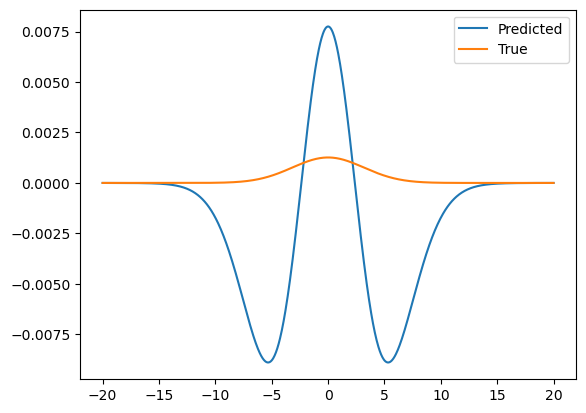

index 49950 was the worst result with an MSE of 0.017949509292919982 for V=10.0 and H_0=3.0


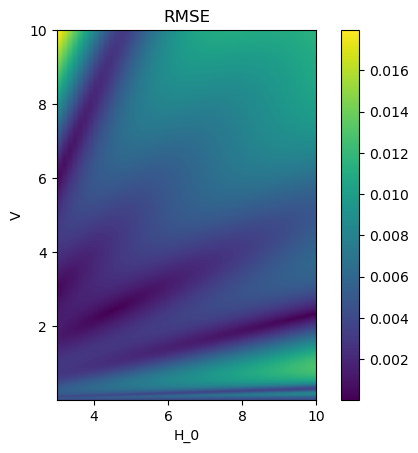

In [10]:
y_test_pred = reg.predict(x_test)

plt.figure()
plt.plot(x, y_test_pred[0, :], label='Predicted')
plt.plot(x, y_test[0, :], label='True')
plt.legend()
plt.show()

rmse = reg.test(x_test, y_test)

worst_index_rmse = int(np.where(rmse == np.max(rmse))[0])
print(f'index {worst_index_rmse} was the worst result with an MSE of {mse[worst_index_rmse]} for V={test_params[worst_index_rmse, 0]} and H_0={test_params[worst_index_rmse, 1]}')

test_params_arr = test_params.reshape((n_samples_V_test, n_samples_H_0_test, 2))
rmse_arr = rmse.reshape((n_samples_V_test, n_samples_H_0_test))

plt.figure()
plt.imshow(rmse_arr[:, :], origin='lower', extent=[H_0_arr_test[0], H_0_arr_test[-1], V_arr_test[0], V_arr_test[-1]])
plt.colorbar()
plt.xlabel('H_0')
plt.ylabel('V')
plt.title('RMSE')
plt.show()
